## Pendulum simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import pydae.svg_tools as svgt
%config InlineBackend.figure_format = 'svg'
plt.ion()

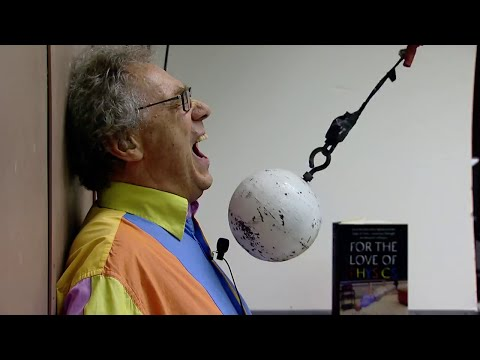

In [2]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('4a0FbQdH3dY')

Before simulating we need to import the class from the build module:

In [3]:
from pydae import ssa
import pendulum

Then you can create an instance of the class:

In [4]:
pend = pendulum.model()

### Initialization

The `initialize` method gives the steady state of the system by solving first the backward and then the forward problems.
In this case 

In [5]:
M = 30.0  # mass of the bob (kg)
L = 5.21  # length of the pendulum (m)
pend.ini({'M':M,'L':L,           # parameters setting
          'theta':np.deg2rad(0)  # initial desired angle = 0º
          },-1)                  # here -1 means that -1 is considered as initial gess for
                                 # dynamic and algebraic states


True

Once the system is initialized we can show the obtained variable values:

In [6]:
pend.report_x()  # obtained dynamic states
pend.report_y()  # obtained algebraic states
pend.report_z()  # obtained outputs
pend.report_u()  # obtained algebraic states (theta is both state and output; f_x is both input and output)
pend.report_params()  # considered parameters

p_x   =  0.00
p_y   = -5.21
v_x   =  0.00
v_y   =  0.00
lam   = 28.24
theta =  0.00
E_p   = -0.00
E_k   =  0.00
f_x   = -0.00
f_x   =-0.00
L     = 5.21
G     = 9.81
M     =30.00
K_d   = 0.00


Another option to get values is to use the `get_value` method. Let's use it and then calculate the oscillation period of the pendulum as:

$$ 
T = 2\pi \sqrt{\frac{L}{G}}
$$

In [7]:
G = pend.get_value('G')
L = pend.get_value('L')

T = 2*np.pi*np.sqrt(L/G)

print(f'Oscillation period with formula: T = {T:0.2f} s')

Oscillation period with formula: T = 4.58 s


### Small signal analisys

After the system is initialized we can perform a small signal analysis. The `pydae.ssa` module has a method called `eval_A` to compute the matrix $A$ for the system:

$$
\Delta \mathbf{\dot {x}} = \mathbf{A}\Delta \mathbf{x}  
$$

In [8]:
ssa.A_eval(pend)              # method to linealized the system and to compute matrix A
eig_df=ssa.damp_report(pend)  # method to create a pandas.DataFrame after computing eigenvalues for A
eig_df

,Real,Imag,Freq.,Damp
Mode 1,-0.000017,1.372194,0.218391,1.214600e-05
Mode 2,-0.000017,-1.372194,0.218391,1.214600e-05
Mode 3,-0.000017,1902.424501,302.780263,8.760751e-09
Mode 4,-0.000017,-1902.424501,302.780263,8.760751e-09


Using mode analysis the period of the pendulum can be computes choosing the third mode **Mode 1**:

In [9]:
freq = eig_df['Freq.']['Mode 1']   # frequency of Mode 3 (Hz)
period = 1/freq                    # oscillation period
print(f'Oscillation period from small signal analysis: T = {period:0.2f} s')

Oscillation period from small signal analysis: T = 4.58 s


### Simulation

A time simulation can be performed using the method `simulate`:


In [10]:
pend.ini({'f_x':0,'M':M,'L':L,'theta':np.deg2rad(-5)},-1) # initilize the system with theta = -5º 
pend.run( 1.0, {})         # run until t=1s
pend.run(50.0, {'f_x':0})  # release the pendulum by making the f_x force equal zero  
pend.post();               # close the simulation 

Oscillation period from simulation: T = 4.58 s


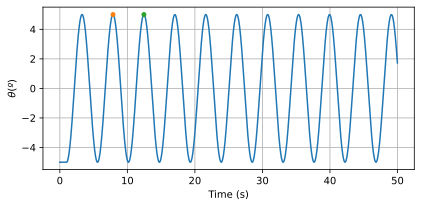

In [11]:
time = pend.Time                              # gets the simulated times
theta = np.rad2deg(pend.get_values('theta'))  # gets the values for theta (and covert them from rad to deg)

# this is just to find the period of the theta oscillation:
idx_1 = np.where(theta==np.max(theta[(time>7)&(time<11)]))[0][0]     
idx_2 = np.where(theta==np.max(theta[(time>10)&(time<14)]))[0][0]
t_1 = time[idx_1]
t_2 = time[idx_2]

period_sim = t_2 - t_1

# plotting the results with matplolib:
plt.close('all')
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(6, 3), dpi=100)

axes.plot(pend.Time, np.rad2deg(pend.get_values('theta')), label=f'$\theta$')
axes.plot(t_1, np.rad2deg(pend.get_values('theta')[idx_1]),'o',ms=4)
axes.plot(t_2, np.rad2deg(pend.get_values('theta')[idx_2]),'o',ms=4)
axes.grid()
axes.set_ylabel('$\\theta (º)$')
axes.set_xlabel('Time (s)')
fig.tight_layout()

print(f'Oscillation period from simulation: T = {period_sim:0.2f} s')

#### Animation of the results

The obtained results can be animated. 

In [12]:
from importlib import reload  
reload(svgt)
anim = svgt.animatesvg('../svg/pendulum_1_fx.svg','pendulum')
anim.set_size(600,400)

# start button:
anim.begin_click = True
anim.group_id = 'play'
anim.anim_id = 'play_1'
anim.translate(np.array([0.,3.]),np.array([0.0,0.0]),np.array([0.0,0.0]))

# pendulum:
anim.group_id = 'pendulum'
anim.begin_click = False
anim.anim_id = ''
anim.begin = 'play_1.begin'

times = pend.Time
anim.rotate(times,-np.rad2deg(pend.get_values('theta')),73.327,31.538)

# force:
x = pend.get_values('p_x')*10
y = -10*(5.21+pend.get_values('p_y'))

f_x = -pend.get_values('f_x')*0.05

anim.group_id = 'f_x_pos'
anim.begin = 'play_1.begin'
s_x = -np.copy(f_x)
s_x[s_x<0] = 0.0
s_y = s_x
anim.scale(pend.Time,72.019669,83.537544,s_x,s_y)
anim.translate(pend.Time,x,y)

anim.group_id = 'f_x_neg'
anim.begin = 'play_1.begin'
s_x = np.copy(f_x)
s_x[s_x<0] = 0.0
s_y = s_x
anim.scale(pend.Time,74.635086,83.537544,s_x,s_y)
anim.translate(pend.Time,x,y)

anim.save('pendulum_5deg.svg')
HTML('pendulum_5deg.svg')

Let's supposed that we want to show that the period depends very little on the amplitude (if we consider a samll one). We can simulate twice and then compare the results:

- `p_5`: system for initial position of 5º
- `p_10`: system for initial position of 10º

In [13]:
p_5  = pendulum.model()
p_10 = pendulum.model()
M = 30.0
L = 5.21

p_5.ini({'f_x':0,'M':M,'L':L,'theta':np.deg2rad(-5)},-1)
p_5.run( 1.0, {})
p_5.run(50.0, {'f_x':0})
p_5.post()

p_10.ini({'f_x':0,'M':M,'L':L,'theta':np.deg2rad(-10)},-1)
p_10.run( 1.0, {})
p_10.run(50.0, {'f_x':0})
p_10.post()


In [14]:
anim = svgt.animatesvg('../svg/pendulum_2.svg','pendulum_1')
anim.set_size(600,400)

# start button:
anim.begin_click = True
anim.group_id = 'play'
anim.anim_id = 'play_anim_2'
anim.scale(np.array([0,1.0]),np.array([1.,1.]),np.array([1.,1.]),np.array([1.,1.]),np.array([1.,1.0]))
anim.anim_id = ''

# pendulums:
anim.group_id = 'pendulum_1'
anim.begin_click = False
anim.begin = 'play_anim_2.begin'

anim.rotate(p_5.Time,-np.rad2deg(p_5.get_values('theta')),73.327,31.538)
anim.group_id = 'pendulum_2'
anim.rotate(p_10.Time,-np.rad2deg(p_10.get_values('theta')),73.327,31.538)

anim.save('pendulum_5deg_10deg.svg')
HTML('pendulum_5deg_10deg.svg')

Now we can check that mass does not affect the oscillation period:

In [15]:
p_m30 = pendulum.model()
p_m105 = pendulum.model()

p_m30.ini({'f_x':0,'M':30,'L':L,'theta':np.deg2rad(0)},-1)
p_m105.ini({'f_x':0,'M':30+75,'L':L,'theta':np.deg2rad(0)},-0.1)
p_m105.report_x()
p_m105.report_y()
ssa.A_eval(p_m30)
ssa.A_eval(p_m105)

eig_df_m30 = ssa.damp_report(p_m30)
eig_df_m105 = ssa.damp_report(p_m105)


p_x   =  0.00
p_y   = -5.21
v_x   =  0.00
v_y   =  0.00
lam   = 98.85
theta =  0.00


In [16]:
freq_m30 = eig_df_m30['Freq.']['Mode 1']   # frequency of Mode 1 (Hz)
freq_m105 = eig_df_m105['Freq.']['Mode 1']   # frequency of Mode 1 (Hz)

print(f'Oscillation period from small signal analysis with M = 30 kg:  T = {1/freq_m30:0.2f} s')
print(f'Oscillation period from small signal analysis with M = 105 kg: T = {1/freq_m105:0.2f} s')

Oscillation period from small signal analysis with M = 30 kg:  T = 4.58 s
Oscillation period from small signal analysis with M = 105 kg: T = 4.58 s


In [17]:
pend_push =  pendulum.model()
pend_push.ini({'f_x':0,'M':30,'L':L,'theta':np.deg2rad(-10)},-1)

pend_push.run( 1.0,{'theta':np.deg2rad(-10)})  # initilize the system with theta = -5º and run until t=1s
pend_push.run( 1.5,{'f_x':20.0})               # release the pendulum by but applying a positive force equal
pend_push.run(10.0,{'f_x': 0.0})               # release the pendulum
pend_push.post();                        

In [18]:
from importlib import reload  
reload(svgt)
anim = svgt.animatesvg('../svg/pendulum_1_fx.svg','pendulum')
anim.set_size(600,400)

# start button:
anim.begin_click = True
anim.group_id = 'play'
anim.anim_id = 'play_anim_3'
anim.translate(np.array([0.,3.]),np.array([0.0,0.1]),np.array([0.0,0.1]))
anim.anim_id = ''

# pendulum:
anim.group_id = 'pendulum'
anim.begin_click = False
anim.anim_id = 'pendulum_anim'
anim.begin = 'play_anim_3.begin'

times = pend_push.Time
anim.rotate(times,-np.rad2deg(pend_push.get_values('theta')),73.327,31.538)

# force:
x = pend_push.get_values('p_x')*10
y = -10*(5.21+pend_push.get_values('p_y'))

f_x = -pend_push.get_values('f_x')*0.05

anim.group_id = 'f_x_pos'
anim.begin = 'play_anim_3.begin'
#anim.begin = 'click'
s_x = -np.copy(f_x)
s_x[s_x<0] = 0.0
s_y = s_x
anim.scale(pend_push.Time,72.019669,83.537544,s_x,s_y)
anim.translate(pend_push.Time,x,y)

anim.group_id = 'f_x_neg'
anim.begin = 'play_anim_3.begin'
#anim.begin = 'click'
s_x = np.copy(f_x)
s_x[s_x<0] = 0.0
s_y = s_x
anim.scale(pend_push.Time,74.635086,83.537544,s_x,s_y)
anim.translate(pend_push.Time,x,y)

anim.save('pendulum_10deg_push.svg')

HTML('pendulum_10deg_push.svg')

### Control

#### Simulation for control testing

In [19]:
Δt = 0.1
p_ctrl = pendulum.model()
times = np.arange(0,30,Δt)
p_ctrl.ini({'M':30,'L':5.21,'theta':np.deg2rad(-10)},-1)

f_x_0 = p_ctrl.get_value('f_x')
for t in times:
    f_x = f_x_0
    if t>2.0:
        f_x = 0.0
    p_ctrl.run(t,{'f_x':f_x})
    
p_ctrl.post();


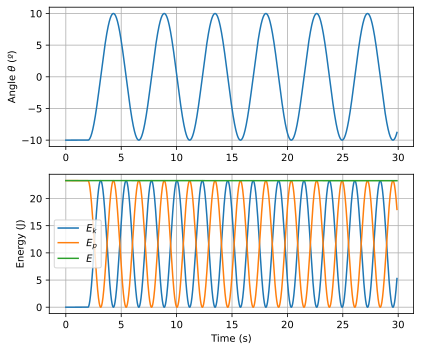

In [20]:
# plotting the results with matplolib:
plt.close('all')
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(6, 5), dpi=100)

axes[0].plot(p_ctrl.Time, np.rad2deg(p_ctrl.get_values('theta')), label=f'$\theta$')
E_k = p_ctrl.get_values('E_k')
E_p = p_ctrl.get_values('E_p')
axes[1].plot(p_ctrl.Time, E_k, label=f'$E_k$')
axes[1].plot(p_ctrl.Time, E_p, label=f'$E_p$')
axes[1].plot(p_ctrl.Time, E_k+E_p, label=f'$E$')

axes[0].grid()
axes[1].grid()
axes[1].legend()
axes[0].set_ylabel('Angle $\\theta\; (º)$')
axes[1].set_ylabel('Energy (J)')
axes[1].set_xlabel('Time (s)')
fig.tight_layout()


#### Basic porportional regulator

Now we are going to propose a control law as follows:

$$
\Delta f_x = - K v_x
$$

$$
f_x = f_h + \Delta f_x 
$$

where $f_x$ is the hand effort and $\Delta f_x$ is the controller force increment.

In [21]:
Δt = 0.1
p_ctrl = pendulum.model()
times = np.arange(0,25,Δt)
p_ctrl.ini({'M':30,'L':5.21,'theta':np.deg2rad(-10)},-1)

K = 20.0
f_x_0 = p_ctrl.get_value('f_x')
for t in times:
    f_x_hand = f_x_0
    if t>2.0:
        f_x_hand = 0.0
    
    v_x = p_ctrl.get_value('v_x')        # speed in x measurement
     
    f_x = f_x_hand - K*v_x            # control law
    
    p_ctrl.run(t,{'f_x':f_x})  # simulation until t(k+1) =  Δt + t(k) with the updated f_x force 
    
p_ctrl.post();  # required post processing


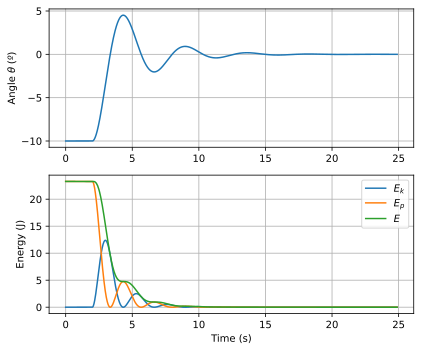

In [22]:
# plotting the results with matplolib:
plt.close('all')
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(6, 5), dpi=100)

axes[0].plot(p_ctrl.Time, np.rad2deg(p_ctrl.get_values('theta')), label=f'$\theta$')
E_k = p_ctrl.get_values('E_k')
E_p = p_ctrl.get_values('E_p')
axes[1].plot(p_ctrl.Time, E_k, label=f'$E_k$')
axes[1].plot(p_ctrl.Time, E_p, label=f'$E_p$')
axes[1].plot(p_ctrl.Time, E_k+E_p, label=f'$E$')

axes[0].grid()
axes[1].grid()
axes[1].legend()
axes[0].set_ylabel('Angle $\\theta\; (º)$')
axes[1].set_ylabel('Energy (J)')
axes[1].set_xlabel('Time (s)')
fig.tight_layout()

In [23]:
anim = svgt.animatesvg('../svg/pendulum_1_fx.svg','pendulum')
anim.set_size(600,400)

# start button:
anim.begin_click = True
anim.group_id = 'play'
anim.anim_id = 'play_anim_4'
anim.scale(np.array([0,10000.0]),np.array([1.,1.])*1.715,np.array([1.,1.])*1.847,np.array([1.,1.]),np.array([1,1]))
anim.anim_id = ''

# pendulum:
anim.group_id = 'pendulum'
anim.anim_id = 'pendulum_anim'
anim.begin_click = False
anim.begin = 'play_anim_4.begin'
times = p_ctrl.Time
anim.rotate(times,-np.rad2deg(p_ctrl.get_values('theta')),73.327,31.538)

x = p_ctrl.get_values('p_x')*10
y = -10*(5.21+p_ctrl.get_values('p_y'))

f_x = -p_ctrl.get_values('f_x')*0.05

anim.group_id = 'f_x_pos'
anim.anim_id = 'f_x_pos_anim'
anim.begin = 'play_anim_4.begin'
s_x = -np.copy(f_x)
s_x[s_x<0] = 0.0
s_y = s_x
anim.scale(p_ctrl.Time,72.019669,83.537544,s_x,s_y)
anim.translate(p_ctrl.Time,x,y)

anim.group_id = 'f_x_neg'
anim.anim_id = 'f_x_neg_anim'
anim.begin = 'play_anim_4.begin'
s_x = np.copy(f_x)
s_x[s_x<0] = 0.0
s_y = s_x
anim.scale(p_ctrl.Time,74.635086,83.537544,s_x,s_y)
anim.translate(p_ctrl.Time,x,y)


anim.save('pendulum_ctrl.svg')
HTML('pendulum_ctrl.svg')

#### On-off control

In [24]:
Δt = 0.1
p_ctrl = pendulum.model()
times = np.arange(0,25,Δt)
p_ctrl.ini({'M':30,'L':5.21,'theta':np.deg2rad(-10)},-1)

K = 20.0
f_x_0 = p_ctrl.get_value('f_x')
for t in times:
    f_x_hand = f_x_0
    if t>2.0:
        f_x_hand = 0.0
    
    p_x = p_ctrl.get_value('p_x')        # position in x measurement
    v_x = p_ctrl.get_value('v_x')        # speed in x measurement
     
    f_x = f_x_hand - np.sign(v_x)*5            # control law
    
    p_ctrl.run(t,{'f_x':f_x})  # simulation until t(k+1) =  Δt + t(k) with the updated f_x force 
    
p_ctrl.post();  # required post processing

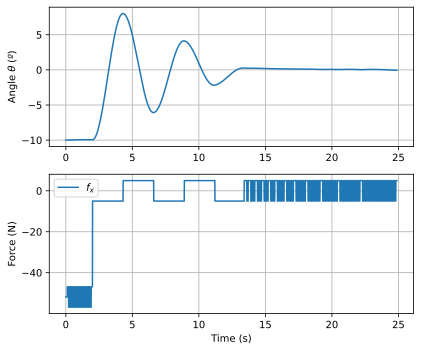

In [25]:
# plotting the results with matplolib:
plt.close('all')
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(6, 5), dpi=100)

axes[0].plot(p_ctrl.Time, np.rad2deg(p_ctrl.get_values('theta')), label=f'$\theta$')
axes[1].plot(p_ctrl.Time, p_ctrl.get_values('f_x'), label=f'$f_x$')


axes[0].grid()
axes[1].grid()
axes[1].legend()
axes[0].set_ylabel('Angle $\\theta\; (º)$')
axes[1].set_ylabel('Force (N)')
axes[1].set_xlabel('Time (s)')

fig.tight_layout()

In [26]:
anim = svgt.animatesvg('../svg/pendulum_1_fx.svg','pendulum')
anim.set_size(600,400)

# start button:
anim.begin_click = True
anim.group_id = 'play'
anim.anim_id = 'play_anim_5'
anim.scale(np.array([0,10000.0]),np.array([1.,1.])*1.715,np.array([1.,1.])*1.847,np.array([1.,1.]),np.array([1,1]))
anim.anim_id = ''

# pendulum:
anim.group_id = 'pendulum'
anim.anim_id = 'pendulum_anim'
anim.begin_click = False
anim.begin = 'play_anim_5.begin'
times = p_ctrl.Time
anim.rotate(times,-np.rad2deg(p_ctrl.get_values('theta')),73.327,31.538)

x = p_ctrl.get_values('p_x')*10
y = -10*(5.21+p_ctrl.get_values('p_y'))

f_x = -p_ctrl.get_values('f_x')*0.05

anim.group_id = 'f_x_pos'
anim.anim_id = 'f_x_pos_anim'
anim.begin = 'play_anim_5.begin'
s_x = -np.copy(f_x)
s_x[s_x<0] = 0.0
s_y = s_x
anim.scale(p_ctrl.Time,72.019669,83.537544,s_x,s_y)
anim.translate(p_ctrl.Time,x,y)

anim.group_id = 'f_x_neg'
anim.anim_id = 'f_x_neg_anim'
anim.begin = 'play_anim_5.begin'
s_x = np.copy(f_x)
s_x[s_x<0] = 0.0
s_y = s_x
anim.scale(p_ctrl.Time,74.635086,83.537544,s_x,s_y)
anim.translate(p_ctrl.Time,x,y)


anim.save('pendulum_ctrl_on_off.svg')
HTML('pendulum_ctrl_on_off.svg')